# Classification Binary - Property - Models

In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from math import factorial, sqrt, fabs
import matplotlib.lines as mlines

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import rv_discrete

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_recall_curve,\
precision_recall_fscore_support
from sklearn.preprocessing import Imputer, label_binarize, LabelEncoder, OneHotEncoder,\
MinMaxScaler, scale
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO
from IPython.display import Image  
from scipy.optimize import minimize
from scipy.stats.distributions import poisson
import pydot

from collections import Counter, defaultdict
import random
import re
random.seed(4444)

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
subset_trainvalid = pd.read_pickle('./dfs/subset_trainvalid')
subset_test = pd.read_pickle('./dfs/subset_test')

## Model features

In [3]:
features = ['DAMAGE_PROPERTY', 'DAMAGE_PROPERTY_YES',  
            'EVENT_CATEGORY', 'SEASON', 'BEGIN_YEAR', 
             'LAT', 'LON', 'TOR_F_SCALE',
            'STATE']
            #'MAGNITUDE', 'CATEGORY', 'DURATION', 'BEGIN_RANGE'
            # 'WFO'
df_trainvalid = subset_trainvalid.loc[:,features]
df_test = subset_test.loc[:,features]
feat_cat = ['EVENT_CATEGORY', 'SEASON', 'BEGIN_YEAR', 'STATE', 'TOR_F_SCALE']
for item in feat_cat:
    df_trainvalid[item] = df_trainvalid[item].astype('category')
    df_test[item] = df_test[item].astype('category')

### Property damage missing values

In [4]:
df_trainvalid = df_trainvalid.loc[df_trainvalid.DAMAGE_PROPERTY.notnull(),:]
df_test = df_test.loc[df_test.DAMAGE_PROPERTY.notnull(),:]

## Dividing data into training-valid sets

In [5]:
df_train, df_valid = train_test_split(df_trainvalid, test_size = 0.25)

## no missing values
#df_train = df_train.loc[ df_train.EVENT_CATEGORY.notnull(),:]
#l = 1.0*len(df_train)
#for name in df_train.columns.values:
#    ln = len(df_train[df_train[name].isnull()])
#    print name, ln/l

## Dummies for categorical variables

In [6]:
yproperty_train = df_train['DAMAGE_PROPERTY_YES']
yproperty_valid = df_valid['DAMAGE_PROPERTY_YES']
yproperty_trainvalid = df_trainvalid['DAMAGE_PROPERTY_YES']
yproperty_test = df_test['DAMAGE_PROPERTY_YES']
Xid_train = df_train.loc[:,'EVENT_CATEGORY':]
Xid_valid = df_valid.loc[:,'EVENT_CATEGORY':]
Xid_trainvalid = df_trainvalid.loc[:,'EVENT_CATEGORY':]
Xid_test = df_test.loc[:,'EVENT_CATEGORY':]
Xid_train = pd.get_dummies(Xid_train)
Xid_valid = pd.get_dummies(Xid_valid)
Xid_trainvalid = pd.get_dummies(Xid_trainvalid)
Xid_test = pd.get_dummies(Xid_test)
print yproperty_train.value_counts()
print len(df_trainvalid) + len(df_test)
print Xid_test.shape, yproperty_test.shape
print Xid_trainvalid.shape, yproperty_trainvalid.shape
print Xid_valid.shape, yproperty_valid.shape
print Xid_train.shape, yproperty_train.shape

0.0    219226
1.0    164259
Name: DAMAGE_PROPERTY_YES, dtype: int64
639344
(128030, 101) (128030,)
(511314, 101) (511314,)
(127829, 101) (127829,)
(383485, 101) (383485,)


# Model

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def mean_cross_val_score(estimator, X, y, cv=None, scoring=None, n_jobs=1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    scores_mean = np.mean(scores)
    return scores_mean

def baseline_predictor(y_train, n):
    labels = y_train.unique()
    return [Counter(y_train).most_common(1)[0][0]]*n

### Baseline predictor

In [8]:
yproperty_predbp = baseline_predictor(yproperty_train, len(Xid_valid))
print 'Baseline Predictor - Test accuracy:', 
print accuracy_score(yproperty_valid, yproperty_predbp),'\n'
print classification_report(yproperty_valid, yproperty_predbp),'\n'
print confusion_matrix(yproperty_valid, yproperty_predbp), '\n'

Baseline Predictor - Test accuracy: 0.571951591579 

             precision    recall  f1-score   support

        0.0       0.57      1.00      0.73     73112
        1.0       0.00      0.00      0.00     54717

avg / total       0.33      0.57      0.42    127829


[[73112     0]
 [54717     0]] 



/home/lucia/anaconda2/lib/python2.7/site-packages/scikit_learn-0.17.1-py2.7-linux-x86_64.egg/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC score:  0.5


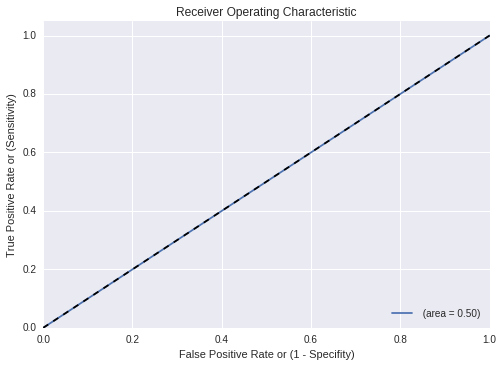

In [9]:
print 'AUC score: ', 
print roc_auc_score(yproperty_valid, yproperty_predbp)  
fpr, tpr, thresholds = roc_curve(yproperty_valid, yproperty_predbp)  
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [10]:
logrzw = LogisticRegression()
modelLRzw = logrzw.fit(Xid_train, yproperty_train) 
yproperty_predLRzw = logrzw.predict(Xid_valid)
print 'Test accuracy for Logistic Regression:', \
accuracy_score(yproperty_valid, yproperty_predLRzw)
print classification_report(yproperty_valid, yproperty_predLRzw),'\n'
print confusion_matrix(yproperty_valid, yproperty_predLRzw)

Test accuracy for Logistic Regression: 0.807586697854
             precision    recall  f1-score   support

        0.0       0.82      0.86      0.84     73112
        1.0       0.80      0.74      0.77     54717

avg / total       0.81      0.81      0.81    127829


[[62689 10423]
 [14173 40544]]


AUC score:  0.799207099853


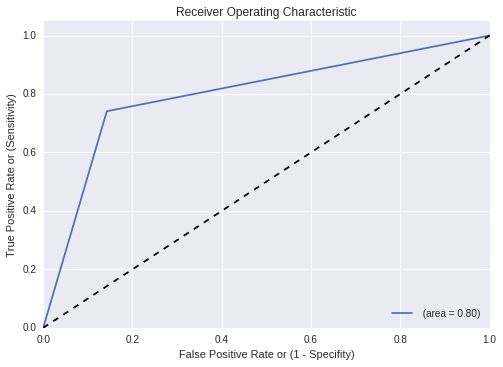

In [11]:
print 'AUC score: ', 
print roc_auc_score(yproperty_valid, yproperty_predLRzw)  
fpr, tpr, thresholds = roc_curve(yproperty_valid, yproperty_predLRzw)  
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Decision Tree and Random Forest

In [12]:
dtc = DecisionTreeClassifier(class_weight='balanced')
modeldtc = dtc.fit(Xid_train, yproperty_train) 
yproperty_predDTC = dtc.predict(Xid_valid)
print 'Test accuracy for Decision Tree Classifier:', \
accuracy_score(yproperty_valid, yproperty_predDTC)
print classification_report(yproperty_valid, yproperty_predDTC),'\n'
print confusion_matrix(yproperty_valid, yproperty_predDTC)

Test accuracy for Decision Tree Classifier: 0.864655125206
             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88     73112
        1.0       0.84      0.84      0.84     54717

avg / total       0.86      0.86      0.86    127829


[[64536  8576]
 [ 8725 45992]]


In [13]:
rfczw = RandomForestClassifier()
modelrfczw = rfczw.fit(Xid_train, yproperty_train) 
yproperty_predRFzw = rfczw.predict(Xid_valid)
acrfczw = accuracy_score(yproperty_valid, yproperty_predRFzw)
print 'Test accuracy for Random Forest Classifier:', acrfczw
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_valid, yproperty_predRFzw),'\n'
print confusion_matrix(yproperty_valid, yproperty_predRFzw)

Test accuracy for Random Forest Classifier: 0.88011327633
             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90     73112
        1.0       0.88      0.83      0.86     54717

avg / total       0.88      0.88      0.88    127829


[[67003  6109]
 [ 9216 45501]]


In [14]:
rfcd30 = RandomForestClassifier(max_depth=30)
modelrfcd30 = rfcd30.fit(Xid_train, yproperty_train) 
yproperty_predRFd30 = rfcd30.predict(Xid_valid)
acrfcd30 = accuracy_score(yproperty_valid, yproperty_predRFd30)
print 'Test accuracy for Random Forest Classifier:', acrfcd30
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_valid, yproperty_predRFd30),'\n'
print confusion_matrix(yproperty_valid, yproperty_predRFd30)

Test accuracy for Random Forest Classifier: 0.87416783359
             precision    recall  f1-score   support

        0.0       0.87      0.91      0.89     73112
        1.0       0.87      0.83      0.85     54717

avg / total       0.87      0.87      0.87    127829


[[66587  6525]
 [ 9560 45157]]


In [15]:
ada = AdaBoostClassifier()
modelada = ada.fit(Xid_train, yproperty_train) 
yproperty_predada = ada.predict(Xid_valid)
acada = accuracy_score(yproperty_valid, yproperty_predada)
print 'Test accuracy for AdaBoost Classifier:', acada
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_valid, yproperty_predada),'\n'
print confusion_matrix(yproperty_valid, yproperty_predada)

Test accuracy for AdaBoost Classifier: 0.801750776428
             precision    recall  f1-score   support

        0.0       0.81      0.85      0.83     73112
        1.0       0.79      0.74      0.76     54717

avg / total       0.80      0.80      0.80    127829


[[62039 11073]
 [14269 40448]]


AUC score:  0.868018091784


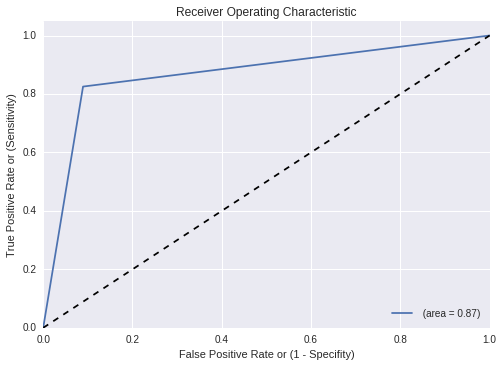

In [16]:
print 'AUC score: ', 
print roc_auc_score(yproperty_valid, yproperty_predRFd30)  
fpr, tpr, thresholds = roc_curve(yproperty_valid, yproperty_predRFd30)  
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Analyzing results

In [17]:
def get_prec_recall(model, X, y):
    proba = model.predict_proba(X)
    proba0 = []
    proba1 = []
    for item in proba:
        proba0.append(item[0])
        proba1.append(item[1])
    return (precision_recall_curve(y, proba0), precision_recall_curve(y, proba1))

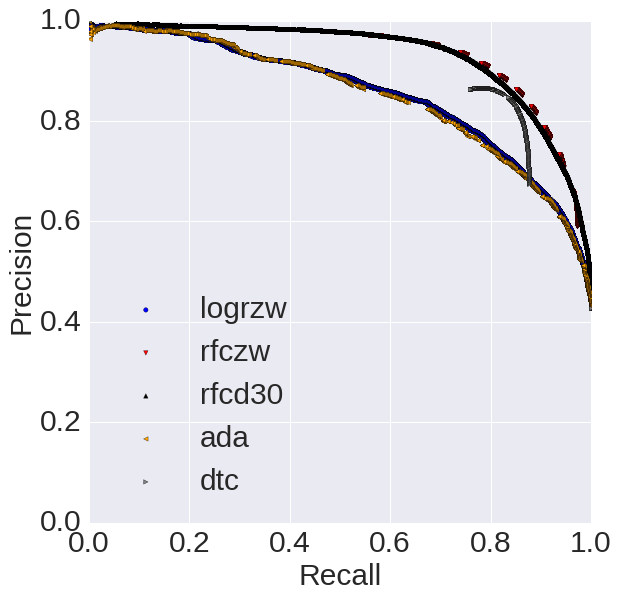

In [18]:
# All models: around 40% recall 20% precision -- dataset cannot be split to 
# nonzero - zero events; inherent to the data structure.
# MORE FEATURES NEEDED
# Here: use 30% recall data point to get new threshold and relabel data to 0 and 1 groups
# Use the rfc20 -- pruned random forest
models = [logrzw, rfczw, rfcd30, ada, dtc ]
names = ['logrzw', 'rfczw', 'rfcd30', 'ada', 'dtc']
colors = ['blue', 'red', 'black', 'orange', 'grey']
sizes = [20]*len(models)
markers = ['o', 'v', '^', '<', '>', '*', 's', 'p', '8', 'h', 'H', 'D', 'd']

plt.clf()
plt.figure(figsize=(9,9))
i = 0
for model in models:
    X = Xid_valid
    prec_rec = get_prec_recall(model, X, yproperty_valid)
    #precision0 = prec_rec[0][0]
    #recall0 = prec_rec[0][1]
    #thresholds0 = prec_rec[0][2]
    precision1 = prec_rec[1][0]
    recall1 = prec_rec[1][1]
    thresholds1 = prec_rec[1][2]
    plt.scatter(recall1, precision1, label = names[i], c=colors[i], s=sizes[i],\
                marker=markers[i])
    plt.xlabel("Recall", fontsize=30)
    plt.ylabel("Precision", fontsize = 30)
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    i += 1
plt.legend(loc=3, fontsize=30)
plt.savefig('./figs/property_models.png', format='png')
plt.show()

### Setting new threshold

In [19]:
# To do: Add cross-validation to pick best recall 
prec_rec = get_prec_recall(rfcd30, Xid_valid, yproperty_valid)
precision1 = prec_rec[1][0]
recall1 = prec_rec[1][1]
thresholds1 = prec_rec[1][2]
summax = 0
imax = 0
for i in range(len(recall1)):
    #minimum = min(recall1,precision1)
    diff = math.fabs(recall1[i]-precision1[i])
    sumi = (recall1[i]+precision1[i])-diff
    if (sumi) > summax:
        summax = sumi       
        imax = i
indexbalance = imax
print precision1[indexbalance], recall1[indexbalance], thresholds1[indexbalance]
epsilonrecall = 0.005
indicesrecall = np.where( np.absolute(recall1 - 1.0) < epsilonrecall )[0]
minimumrecall = np.min(recall1[indicesrecall])
indexrecall = np.where( recall1 == minimumrecall )[0][0]
print precision1[indexrecall], recall1[indexrecall], thresholds1[indexrecall]
epsilonprec = 0.01
#indicesprec = np.where( np.absolute(precision1 - 0.91) < epsilonprec )[0]
indicesprec = np.where( np.absolute(precision1 - 1.0) < epsilonprec )[0]
minimumprec = np.min(precision1[indicesprec])
indexprec = np.where( precision1 == minimumprec )[0][0]
print precision1[indexprec], recall1[indexprec], thresholds1[indexprec]
# Threshold to 0.0358.. so that recall on 1 is 'greatest'

0.849955224153 0.849955224153 0.452249010419
0.521329464824 0.995010691376 0.044269562856
0.990003668379 0.197287863004 0.965350089408


### Run Pruned Random Forest on Test Set

In [20]:
rfcd30test = RandomForestClassifier(max_depth=30)
modelrfcd30test = rfcd30test.fit(Xid_trainvalid, yproperty_trainvalid) 
yproperty_predRFd30test = rfcd30test.predict(Xid_test)
print 'Test accuracy for Random Forest Classifier:', \
accuracy_score(yproperty_test, yproperty_predRFd30test)
print classification_report(yproperty_test, yproperty_predRFd30test),'\n'
print confusion_matrix(yproperty_test, yproperty_predRFd30test)

Test accuracy for Random Forest Classifier: 0.873896742951
             precision    recall  f1-score   support

        0.0       0.87      0.91      0.89     73031
        1.0       0.87      0.83      0.85     54999

avg / total       0.87      0.87      0.87    128030


[[66414  6617]
 [ 9528 45471]]


In [21]:
# Calculate predictions based on new thresholds
probarfcd30 = rfcd30test.predict_proba(Xid_test)
y_predrfc30_adjbalance = []
y_predrfc30_adjrecall = []
y_predrfc30_adjprec = []
for probability in probarfcd30:
    if probability[1] >= thresholds1[indexbalance]:
        y_predrfc30_adjbalance.append(1)
    else:
        y_predrfc30_adjbalance.append(0)
    if probability[1] >= thresholds1[indexrecall]:
        y_predrfc30_adjrecall.append(1)
    else:
        y_predrfc30_adjrecall.append(0)
    if probability[1] >= thresholds1[indexprec]:
        y_predrfc30_adjprec.append(1)
    else:
        y_predrfc30_adjprec.append(0)
y_predrfc30_adjbalance = np.array(y_predrfc30_adjbalance)
y_predrfc30_adjrecall = np.array(y_predrfc30_adjrecall)
y_predrfc30_adjprec = np.array(y_predrfc30_adjprec)

In [22]:
print 'Test accuracy for Adjusted Random Forest Classifier - Balance:'\
, accuracy_score(yproperty_test, y_predrfc30_adjbalance)
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_test, y_predrfc30_adjbalance),'\n'
print confusion_matrix(yproperty_test, y_predrfc30_adjbalance),'\n'
print 'Test accuracy for Adjusted Random Forest Classifier - Recall:'\
, accuracy_score(yproperty_test, y_predrfc30_adjrecall)
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_test, y_predrfc30_adjrecall),'\n'
print confusion_matrix(yproperty_test, y_predrfc30_adjrecall),'\n'
print 'Test accuracy for Adjusted Random Forest Classifier - Precision:'\
, accuracy_score(yproperty_test, y_predrfc30_adjprec)
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yproperty_test, y_predrfc30_adjprec),'\n'
print confusion_matrix(yproperty_test, y_predrfc30_adjprec),'\n'

Test accuracy for Adjusted Random Forest Classifier - Balance: 0.87140513942
             precision    recall  f1-score   support

        0.0       0.89      0.89      0.89     73031
        1.0       0.85      0.85      0.85     54999

avg / total       0.87      0.87      0.87    128030


[[64971  8060]
 [ 8404 46595]] 

Test accuracy for Adjusted Random Forest Classifier - Recall: 0.605045692416
             precision    recall  f1-score   support

        0.0       0.99      0.31      0.47     73031
        1.0       0.52      0.99      0.68     54999

avg / total       0.79      0.61      0.56    128030


[[22760 50271]
 [  295 54704]] 

Test accuracy for Adjusted Random Forest Classifier - Precision: 0.646848394907
             precision    recall  f1-score   support

        0.0       0.62      1.00      0.76     73031
        1.0       0.99      0.18      0.30     54999

avg / total       0.78      0.65      0.57    128030


[[72945    86]
 [45128  9871]] 



In [23]:
def print_confusion_matrix_by_storm(y, figpath):
    y = np.array(y)
    correct_indices = []
    correct_indices.append((yproperty_test == 0) & (y == 0))
    correct_indices.append((yproperty_test == 1) & (y == 1))
    correct_indices.append((yproperty_test == 0) & (y == 1))
    correct_indices.append((yproperty_test == 1) & (y == 0))

    stormsums = defaultdict(list)
    storms = df_test.EVENT_CATEGORY.unique()
    for storm in storms:
        storm_label = 'EVENT_CATEGORY_' + storm
        total = 0
        for i in range(4):
            val = np.sum(np.array(Xid_test.loc[ correct_indices[i], storm_label ]))
            stormsums[i].append(val)
            total += val
        stormsums[4].append(total)

    correct_bystorm = []
    stormsums[4] = np.array(stormsums[4])
    for i in range(5):
        correct_bystorm.append(pd.Series( 1.0*np.array(stormsums[i])/stormsums[4], \
                                         index = storms ).sort_values())

    title = ['True Zero Predictions', 'True Nonzero Predictions', 'Nonzero Predictions Are False',\
            'Zero Predictions Are False']
    plt.figure(figsize=(45,20))
    for i in range(4):
        s = plt.subplot(2,2,i+1)
        correct_bystorm[i].plot(kind = 'barh', title=title[i], fontsize=40, color ='#63d297')
        s.set_title(s.get_title(), fontsize=50, ha='center')
    plt.savefig(figpath)
    plt.show()

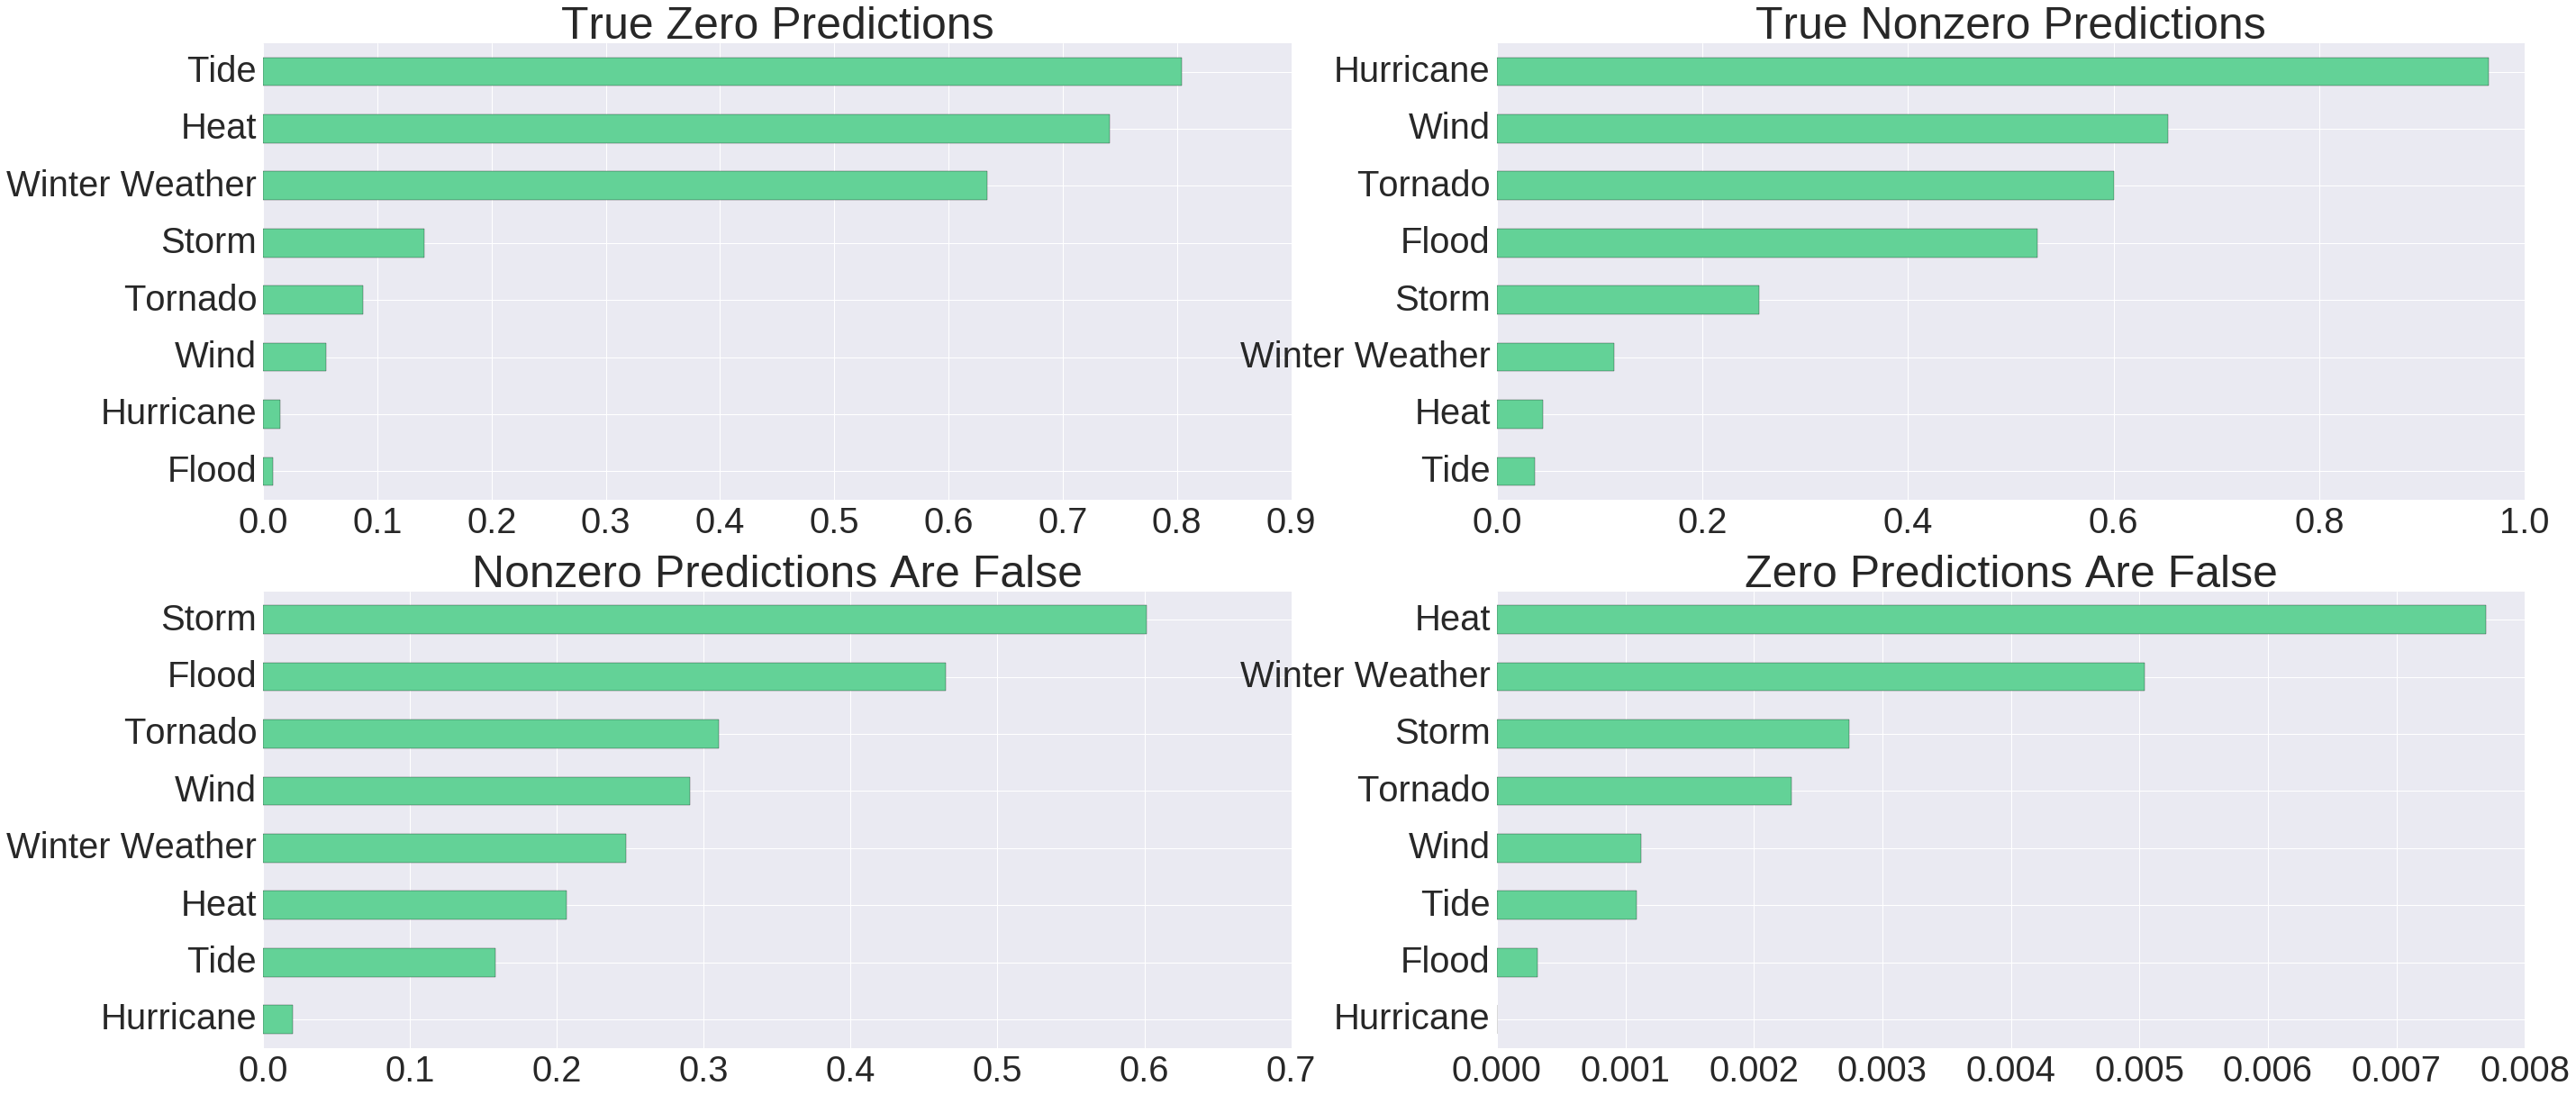

In [24]:
print_confusion_matrix_by_storm(y_predrfc30_adjrecall,
                                './figs/property_rf_accuracy_recall.png')

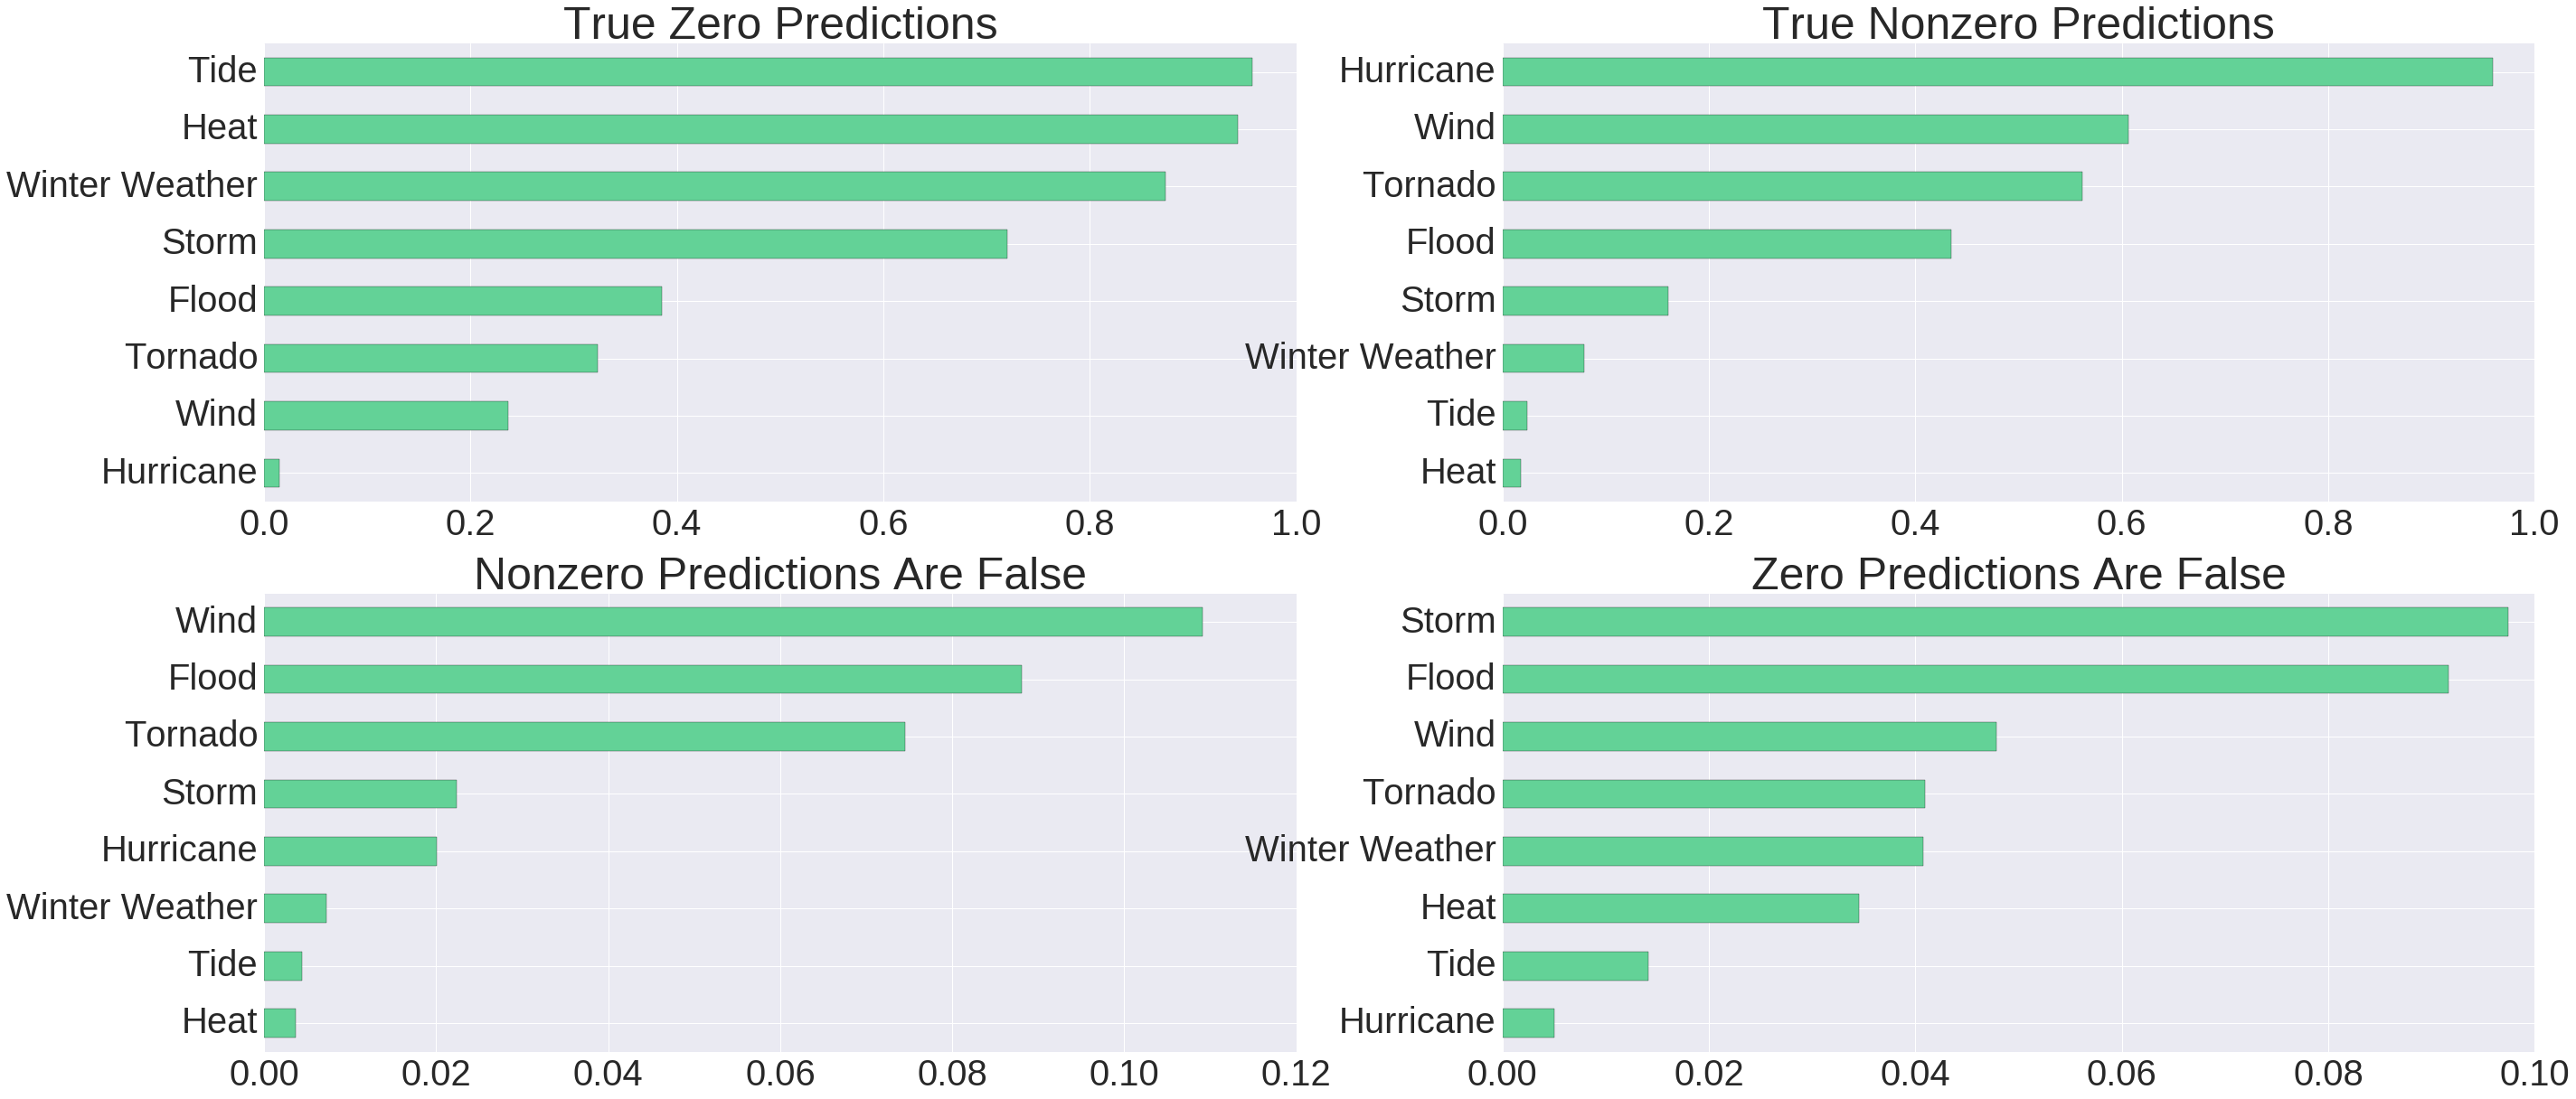

In [25]:
print_confusion_matrix_by_storm(y_predrfc30_adjbalance,
                                './figs/property_rf_accuracy_balance.png')

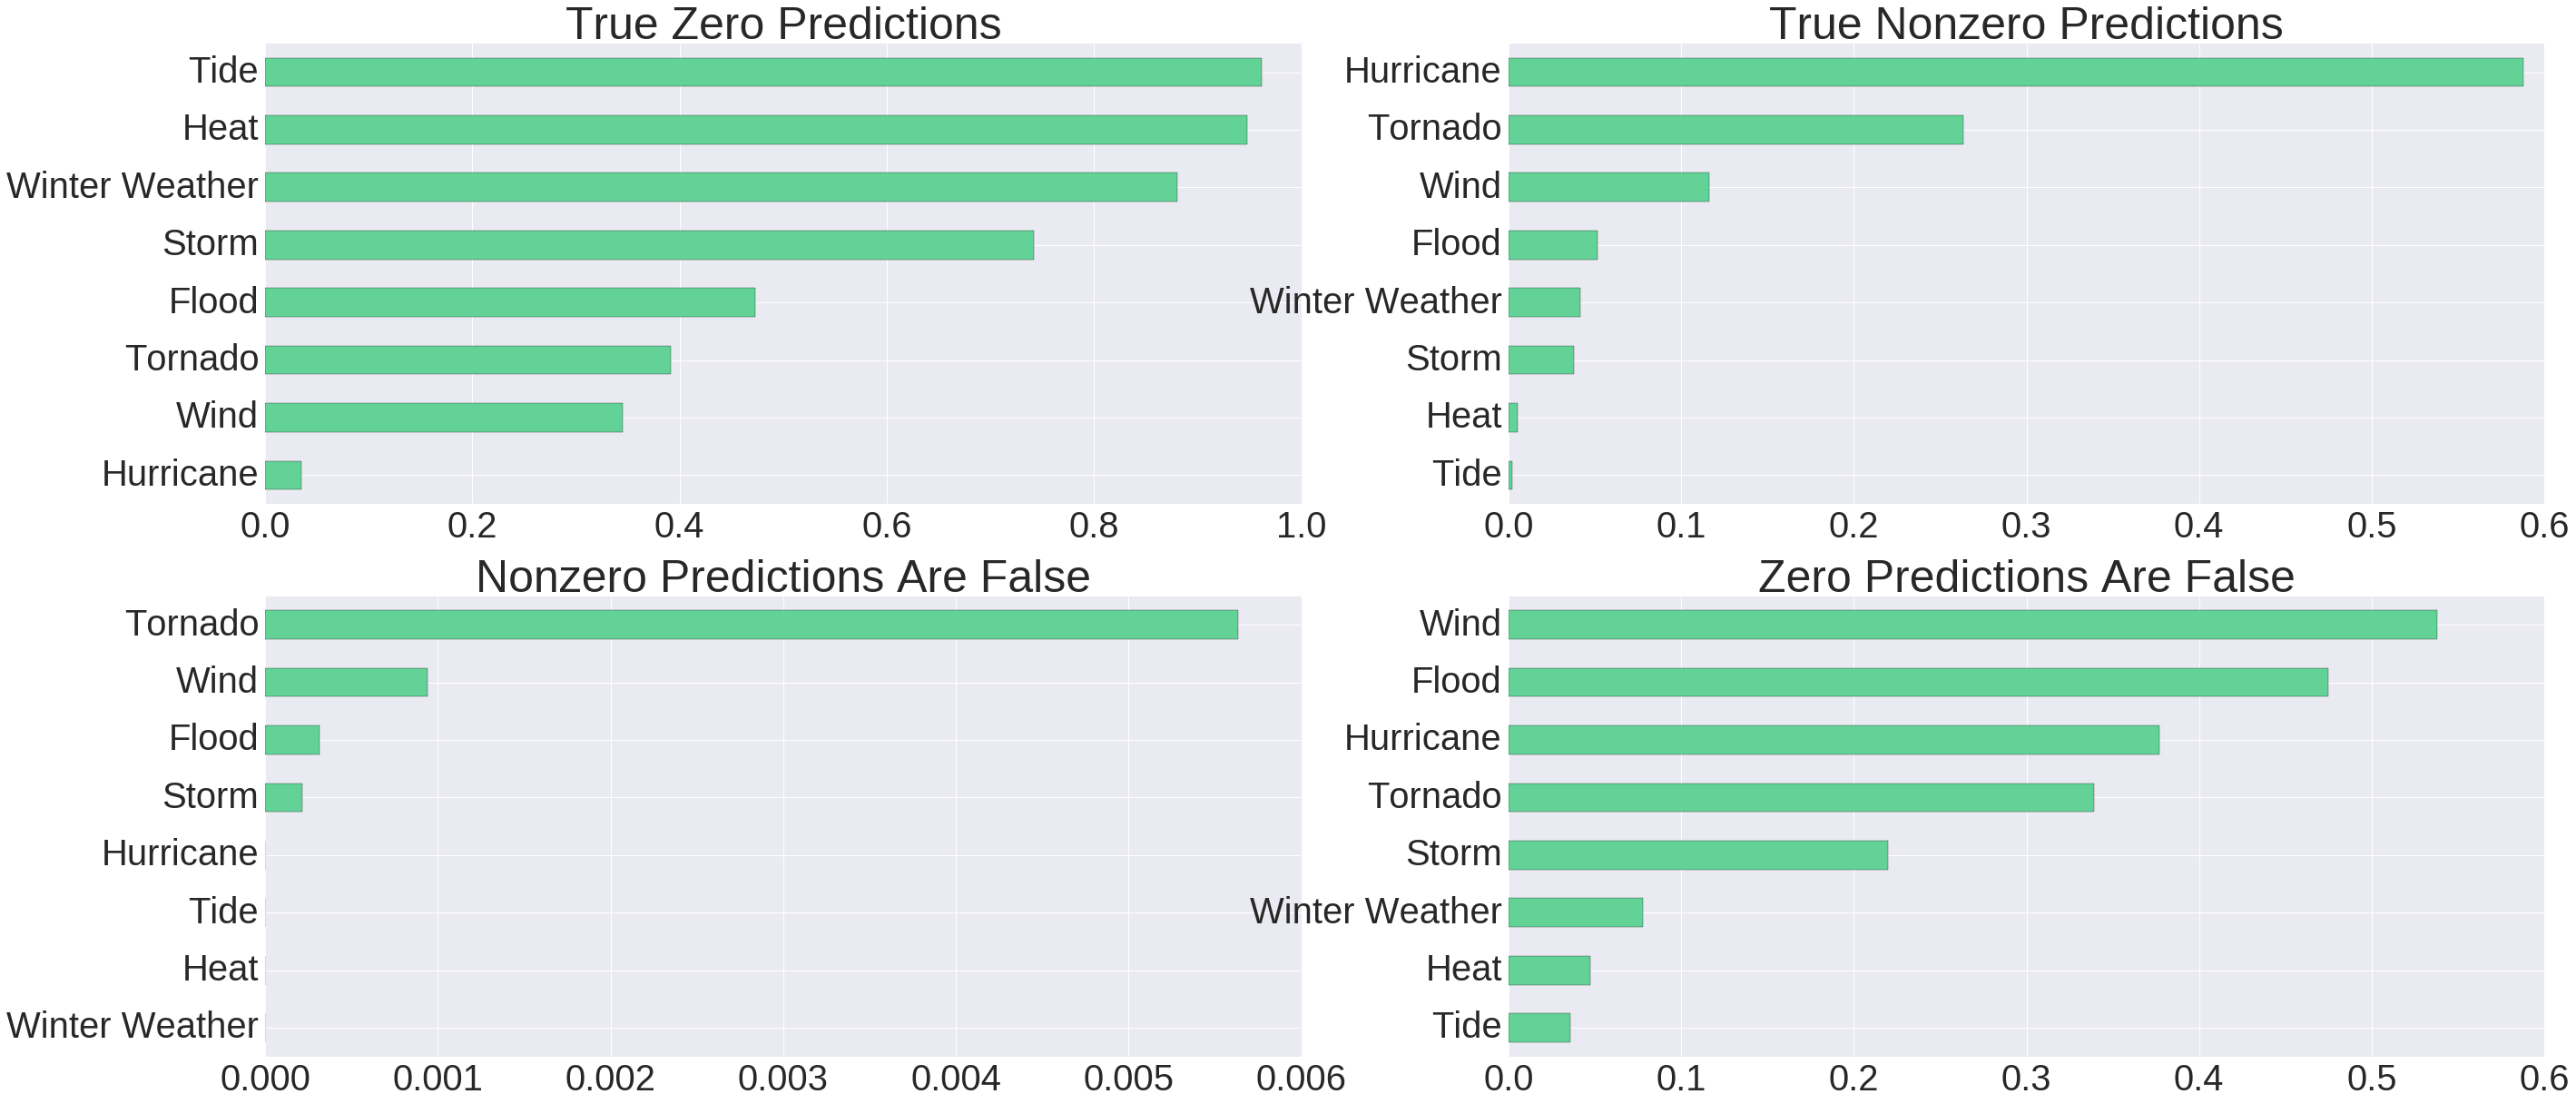

In [26]:
print_confusion_matrix_by_storm(y_predrfc30_adjprec,
                                './figs/property_rf_accuracy_precision.png')

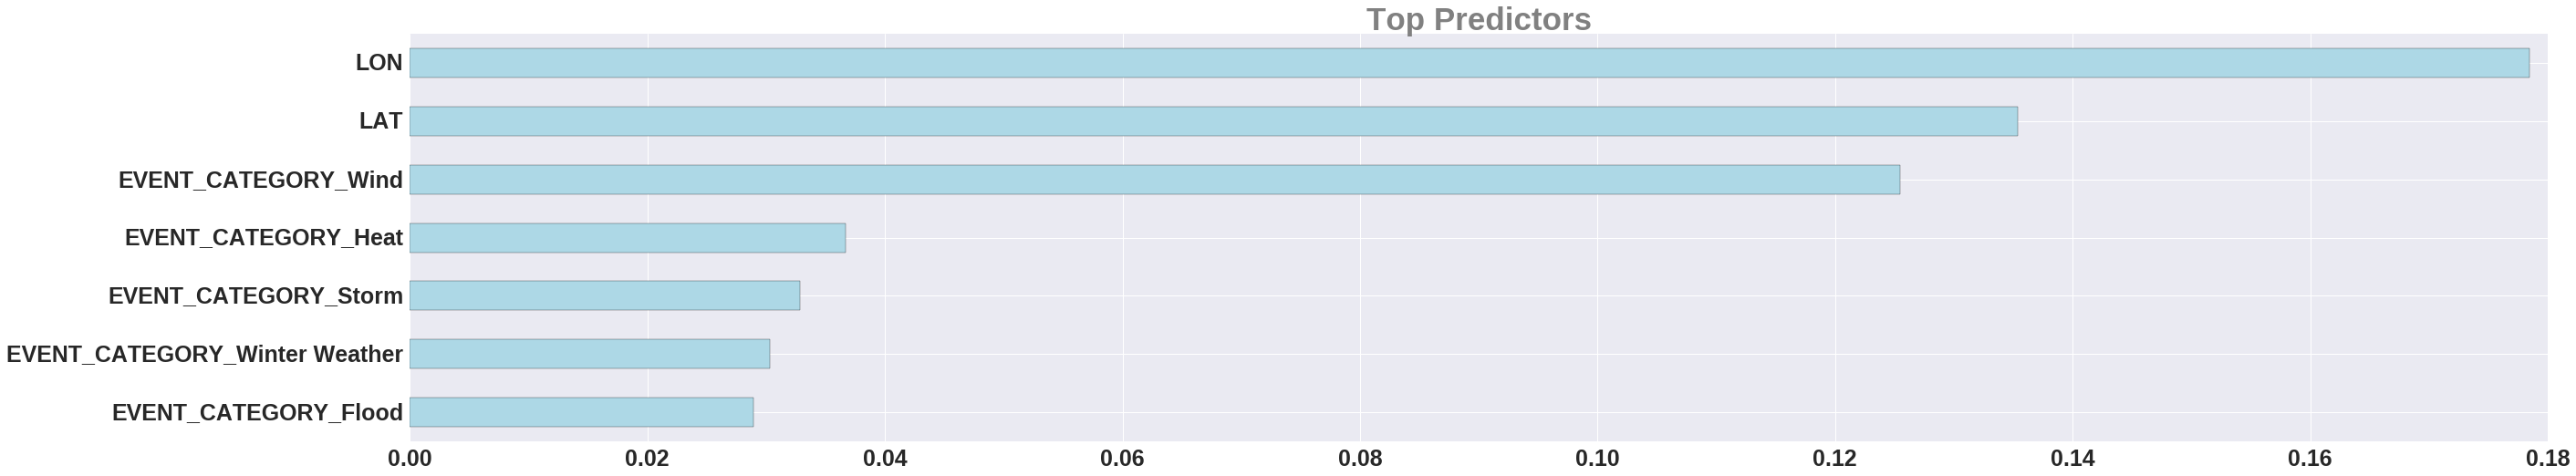

In [38]:
all_features = zip(Xid_test.columns.values, rfcd30test.feature_importances_)
all_features = sorted(all_features, key = lambda x: x[1], reverse=True)
top_features = pd.DataFrame(all_features[:7])
top_features.set_index([0], inplace = True)
top_features.sort_values(by=1, ascending=True, inplace=True)
del top_features.index.name
#print top_features
#plt.clf()
#plt.figure(figsize=(20,5))
#p = top_features.plot(kind = 'barh', title='Top Predictors', fontsize=10, 
#                      legend=False, color ='#63d297')
#p.set_title(p.get_title(), fontsize=20, ha='center')
#plt.savefig('./figs/property_rf_predictors.png', format = 'png', pad_inches = 5)
#plt.show()

plt.close('all')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rc('font', weight='bold')
plt.rcParams["figure.figsize"] = [42,8]
ax = top_features.plot(kind='barh', color ='lightblue',legend=False)
#ax.set_xlabel('Weight',fontsize=30)
#ax.set_ylabel('Predictor',fontsize=30)
ax.set_title('Top Predictors',fontsize=35, color='grey', fontweight='bold')
path = './figs/property_rf_predictors.png'
plt.savefig(path)

### Run Random Forest Regresson only on the labeled ''1'' damages

In [28]:
df_trainvalid_ones = df_trainvalid.loc[df_trainvalid.DAMAGE_PROPERTY_YES != 0,:]
y_trainvalid_ones = df_trainvalid_ones['DAMAGE_PROPERTY']
y_trainvalid_ones_log = np.log(y_trainvalid_ones+1.0)
X_trainvalid_ones = df_trainvalid_ones.loc[:,'EVENT_CATEGORY':]
X_trainvalid_ones = pd.get_dummies(X_trainvalid_ones)
rfc_contv = RandomForestRegressor()
modelrfc_contv = rfc_contv.fit(X_trainvalid_ones, y_trainvalid_ones_log)

In [29]:
for feature in X_trainvalid_ones.columns.values:
    if feature not in Xid_test.columns.values:
        Xid_test[feature] = 0
y_test_log = np.log(yproperty_test+1.0)

In [30]:
# Testing on trainvalid_ones
rfc_contv.score(X_trainvalid_ones, y_trainvalid_ones_log)

0.79304975586045334

In [31]:
# Testing on test set if 0-1 fully separated
df_test_ones = df_test.loc[df_test.DAMAGE_PROPERTY_YES != 0,:]
y_test_ones = df_test_ones['DAMAGE_PROPERTY']
y_test_ones_log = np.log(y_test_ones+1.0)
X_test_ones = df_test_ones.loc[:,'EVENT_CATEGORY':]
X_test_ones = pd.get_dummies(X_test_ones)
rfc_contv.score(X_test_ones, y_test_ones_log)

0.44084428946134258

In [32]:
# Testing on test set if 0-1 separated by y_predrfc30_adjprec
df_test_ones_rec = df_test.loc[ y_predrfc30_adjprec == 1,:]
y_test_ones_rec = df_test_ones_rec['DAMAGE_PROPERTY']
y_test_ones_log_rec = np.log(y_test_ones_rec+1.0)
X_test_ones_rec = df_test_ones_rec.loc[:,'EVENT_CATEGORY':]
X_test_ones_rec = pd.get_dummies(X_test_ones_rec)
rfc_contv.score(X_test_ones_rec, y_test_ones_log_rec)

0.43572813281316303

In [33]:
# Same precision as if guessed mean -- due to 0/1 misclassifications
y_pred_cont_log = rfc_contv.predict(Xid_test)
y_pred_cont = np.exp(y_pred_cont_log)-1.0
y_predrfccont = []
for (a,b) in zip(y_pred_cont, y_predrfc30_adjprec):
    if b == 0:
        y_predrfccont.append(0)
    else:
        y_predrfccont.append(a)
y_predrfccont = pd.Series(y_predrfccont)
print r2_score(df_test.DAMAGE_PROPERTY, y_predrfccont)

0.00147470430993


In [34]:
print accuracy_score(yproperty_test, y_predrfc30_adjprec)
print classification_report(yproperty_test, y_predrfc30_adjprec)

0.646848394907
             precision    recall  f1-score   support

        0.0       0.62      1.00      0.76     73031
        1.0       0.99      0.18      0.30     54999

avg / total       0.78      0.65      0.57    128030



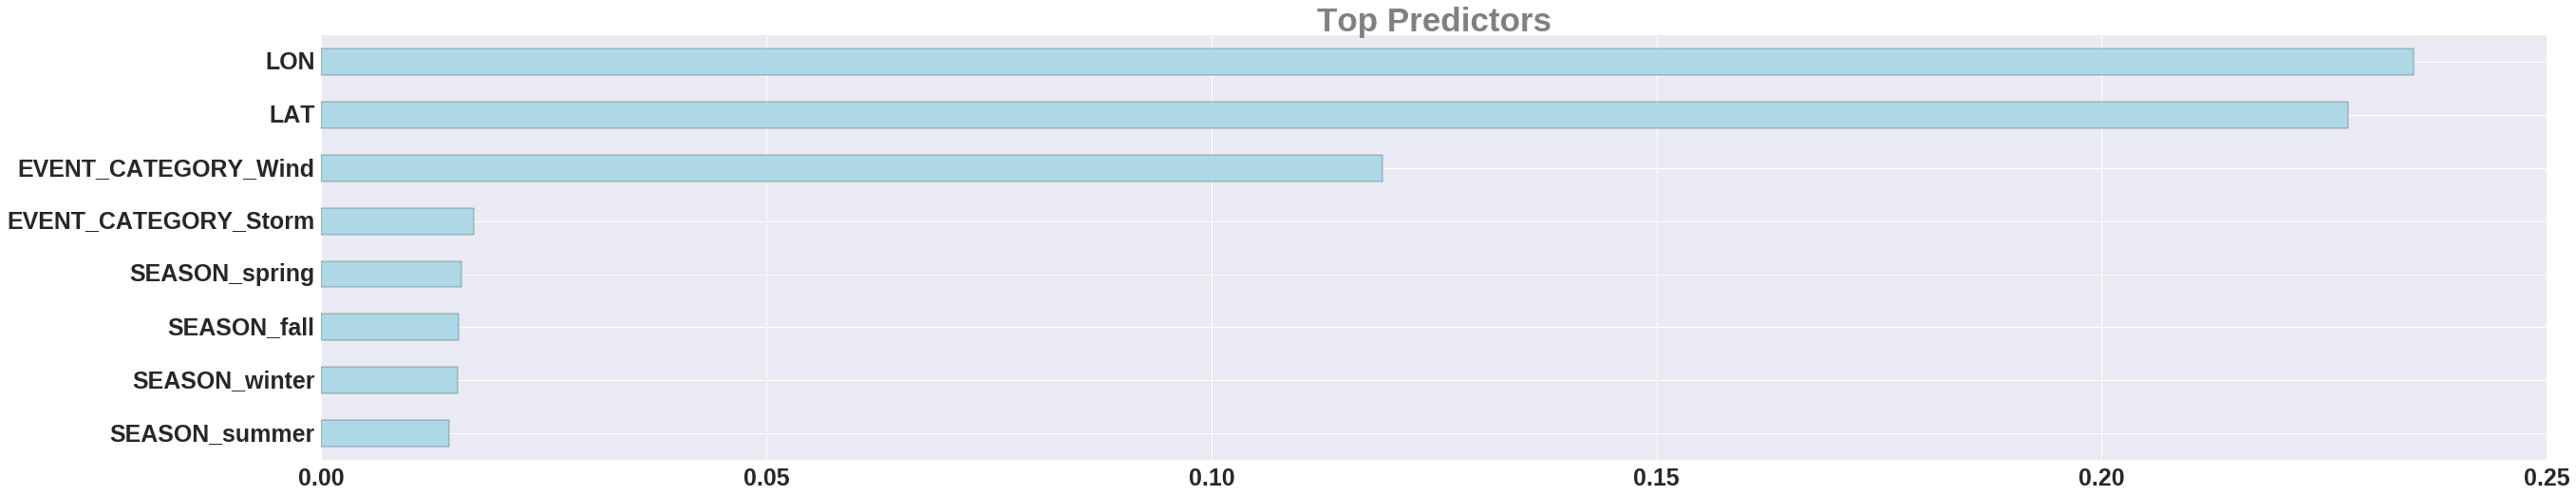

In [41]:
all_features = zip(Xid_test.columns.values, rfc_contv.feature_importances_)
all_features = sorted(all_features, key = lambda x: x[1], reverse=True)
top_features = pd.DataFrame(all_features[:8])
top_features.set_index([0], inplace = True)
top_features.sort_values(by=1, ascending=True, inplace=True)
del top_features.index.name
#print top_features
#plt.clf()
#plt.figure(figsize=(20,5))
#p = top_features.plot(kind = 'barh', title='Top Predictors', fontsize=10, 
#                      legend=False, color ='#63d297')
#p.set_title(p.get_title(), fontsize=20, ha='center')
#plt.savefig('./figs/property_rf_predictors.png', format = 'png', pad_inches = 5)
#plt.show()

plt.close('all')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rc('font', weight='bold')
plt.rcParams["figure.figsize"] = [42,8]
ax = top_features.plot(kind='barh', color ='lightblue',legend=False)
#ax.set_xlabel('Weight',fontsize=30)
#ax.set_ylabel('Predictor',fontsize=30)
ax.set_title('Top Predictors',fontsize=35, color='grey', fontweight='bold')
path = './figs/property_rf_cont_predictors.png'
plt.savefig(path)